# Basit bir Yapay Sinir Ağı (NN)

## Hazırlık

In [1]:
# gerekli kütüphaneler
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# bunlar bize hep lazım
alfabe = list('.abcçdefgğhıijklmnoöprsştuüvyz')
harf2idx = { harf:idx for idx, harf in enumerate(alfabe) }
idx2harf = { idx:harf for harf, idx in harf2idx.items() }

# bize lazım olan işlem: bir string alıp başına ve sonuna nokta ekle
def isle(x):
  return ['.'] + list(x) + ['.']
# bunu da çok kullanacağız
def bigramGetir(x):
  return zip(x, x[1:])

# isimleri okurken işleyelim
isimler =  list(map(lambda isim: isle(isim), open("./isimler.txt", "r").read().splitlines()))
len(isimler)

29996

## Örnekle Başlayalım

Olabilecek en basit NN yapısını elde etmeye çalışacağız ki bu bize bigram model ile neredeyse aynı çıktıları üretecek: önyargı ve aktivasyon bileşenleri olmayacak, tek girdi (bu harf) alacak ve peşinde olduğumuz çıktıyı -sıradaki harf- üretecek.

Artık bigram oluşturmayacağız fakat modeli "x görürsen y üret" şeklinde eğiteceğimiz için harf çiftlerini bu sefer x (girdi) ve y (beklenen çıktı yani _label_) olarak gruplayacağız.

_abacılar_ örneğimizi bu açıdan inceleyelim:

In [2]:
ornekX, ornekY = [], []

for h1, h2 in bigramGetir(isle('abacılar')):
  ornekX.append(harf2idx[h1]) ; ornekY.append(harf2idx[h2])
  print(f'X = {h1} ({harf2idx[h1]:02}) -> Y = {h2} ({harf2idx[h2]:02})')

print(ornekX) ; print(ornekY)

ornekAdet = len(ornekX)
ornekAdetTens, ornekYTens = torch.arange(ornekAdet), torch.tensor(ornekY)

# aşağıdaki kod örneğe dair durumu yazdırmak için:
def prnOrnek(P):
  loss = torch.zeros(ornekAdet)
  for i in range(ornekAdet):
    xi, yi = ornekX[i], ornekY[i]
    p = P[i, yi] ; nll = -torch.log(p)
    print(f'({idx2harf[xi]}:{xi:02}) -> ({idx2harf[yi]}:{yi:02}) p: {p.item():.4f} NLL: {nll.item():.4f}')
    loss[i] = nll
  
  print('=========')
  print(f'NLL: {loss.mean().item():.4f}')


X = . (00) -> Y = a (01)
X = a (01) -> Y = b (02)
X = b (02) -> Y = a (01)
X = a (01) -> Y = c (03)
X = c (03) -> Y = ı (11)
X = ı (11) -> Y = l (15)
X = l (15) -> Y = a (01)
X = a (01) -> Y = r (21)
X = r (21) -> Y = . (00)
[0, 1, 2, 1, 3, 11, 15, 1, 21]
[1, 2, 1, 3, 11, 15, 1, 21, 0]


Tek girdimiz var ama tek ağırlığa sahip olmak zorunda değiliz: Elimizde harfi ifade eden 1-30 arası bir sayı var. Bu sayıyı 30 bitlik bir diziye çevirip nöronu buna göre oluşturduğumuzda tek ağırlık üzerinde cambazlık yapmak yerine 30 farklı ağırlıkla daha hassas bir yapı elde edebiliriz. Yani tek girdiyi 30 parçaya böldük. Nöronumuz w1x1+...+w30x30 şekline büründü (ya da 30 tane tek girdisi olan nörünumuz var diyebilir miyiz?). Bunu uygulamak için camia'nın sevdiği `one_hot` fonksiyonunu kullanacağız:

torch.Size([9, 30])

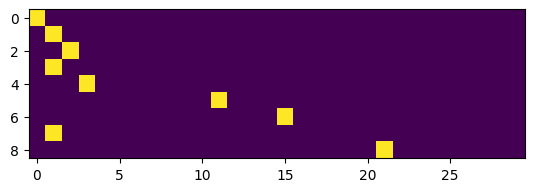

In [3]:
ornekXEncoded = F.one_hot(torch.tensor(ornekX), num_classes = 30).float()
plt.imshow(ornekXEncoded)
ornekXEncoded.shape

Aşağıda rastgele doldurduğumuz ağırlıklar (ve bir önyargı olmayacağı için esasen nöronlar) mevcut:

In [31]:
torch.manual_seed(5)
ornekW = torch.randn((30, 30), requires_grad = True) # requires_grad = True ifadesine dikkat!

Matris çarpımı (@) ile tüm girdileri bir seferde paralel olarak nöronlara veriyoruz. Takip eden iki işlem ise (birlikte) `softmax`. Burada yaptığımız aslında bigram modelimizdeki M ve P'nin muadillerini oluşturmak. Tabii bu bizim saydığımız adetler yerine rastgele rakamlardan oluşuyor. Bu haliyle bir de `loss` hesaplayıp detayları yazdıralım:

In [32]:
logits = ornekXEncoded @ ornekW # "logit": bu işlemin sonucundaki tek öğenin literatürdeki ismi, ve buradaki çoğul hali
# softmax: daha sonra bunun yerine bunu kullanacağız: https://pytorch.org/docs/stable/generated/torch.nn.functional.softmax.html
sankiM = torch.exp(logits)
sankiP = sankiM / sankiM.sum(dim = 1, keepdim = True)

prnOrnek(sankiP)

(.:00) -> (a:01) p: 0.0283 NLL: 3.5640
(a:01) -> (b:02) p: 0.0138 NLL: 4.2799
(b:02) -> (a:01) p: 0.0410 NLL: 3.1946
(a:01) -> (c:03) p: 0.0086 NLL: 4.7506
(c:03) -> (ı:11) p: 0.0159 NLL: 4.1416
(ı:11) -> (l:15) p: 0.0090 NLL: 4.7111
(l:15) -> (a:01) p: 0.0296 NLL: 3.5190
(a:01) -> (r:21) p: 0.0535 NLL: 2.9284
(r:21) -> (.:00) p: 0.0437 NLL: 3.1296
NLL: 3.8021


Örnek ismimiz üzerinden modelimizi eğitelim:

- önce yukarıda açıkça yazdığımız işlemi 1 satırda yapıyoruz. `ornekW` değişkenini oluştururken `requires_grad = True` dediğimiz için bundan türeyen tüm değişkenlerimizde de `grad` hesaplanabilir olacak.
- yine tek satırda loss hesaplıyoruz: her bir satırdaki `ornekY` pozisyonundaki değerleri alıp -log sonrasında ortalamaya tabi tutuyoruz.
- _forward pass_ yaptık!
- _backward pass_ işlemini de `torch` kütüphanesinin yardımıyla tek satırda yapacağız: `loss.backward()` (`loss` `ornekW` değişkeninden türüyor, dikkat!)
- fakat önce `grad` değerlerini temizliyoruz (kütüphane `grad` için hesapladığı değeri mevcut değere eklediği için bunu yapıyoruz).
- artık tek yapmamız gereken ağırlıkları güncelleyip modeli daha iyi bir hale getirmek: burada hesaplanan `grad` değerlerini belli bir katsayı (`learning rate`) ile ağırlıklara ekliyoruz/çıkarıyoruz. Bu katsayı büyüdükçe model daha hızlı istenen noktaya gelebilir ama bu noktayı geçip hızla istenen noktadan öteye de gidebilir. Bir sonraki safhada bunu nasıl optimize edebiliriz bakacağız.

 Nasıl hızla `overfit` olduğuna dikkat edin. Ne kadar uğraşsak bile `loss = 0` olmayacak, peki neden?

In [85]:
# "forward pass"
sankiP = torch.softmax(ornekXEncoded @ ornekW, dim = 1)
loss = -sankiP[ornekAdetTens, ornekYTens].log().mean()

# "backward pass"
ornekW.grad = None # bunu yapmazsak grad değerleri birikir!!
loss.backward()

# update
ornekW.data += -20 * ornekW.grad # LR değerini afaki büyük, ama şimdilik bizim için önemli değil.

prnOrnek(sankiP)


(.:00) -> (a:01) p: 0.9918 NLL: 0.0082
(a:01) -> (b:02) p: 0.5110 NLL: 0.6714
(b:02) -> (a:01) p: 0.9917 NLL: 0.0083
(a:01) -> (c:03) p: 0.3015 NLL: 1.1989
(c:03) -> (ı:11) p: 0.9916 NLL: 0.0084
(ı:11) -> (l:15) p: 0.9916 NLL: 0.0085
(l:15) -> (a:01) p: 0.9916 NLL: 0.0084
(a:01) -> (r:21) p: 0.1801 NLL: 1.7142
(r:21) -> (.:00) p: 0.9917 NLL: 0.0084
NLL: 0.4039


## Tüm Veri Seti ile Eğitim Yapalım

### Hazırlayalım

Temelde yukarıdaki örnek için yaptıklarımızı tüm veri üzerinde yapıyoruz. Biraz `python` öğrenmek adına farklı denemeler yaptım burada:

- X ve Y değerlerini ayırmak için gereken döngüleri _fonksiyonel_ ifadeler arkasına gizledim; bu önceki yöntemden daha mı iyi çalışır?
- `tuple` bir nimet :)

In [98]:
torch.manual_seed(5)

# her isim için bigramları alıp harften sıraya dön; x ve y olarak ayır:
tumu = zip(*[(harf2idx[h1], harf2idx[h2]) for isim in isimler for h1, h2 in bigramGetir(isim)])
tumX, tumY = torch.tensor(list(next(tumu))), torch.tensor(list(next(tumu)))

tumAdet = tumX.nelement()
tumX = F.one_hot(tumX, num_classes = 30).float()
tumAdetTens = torch.arange(tumAdet)

W = torch.randn((30, 30), requires_grad = True)
tumAdet

282166

### Eğitelim

Tek örnek için yaptığımız işlemden farklı olarak sadece `loss` değerimizi zenginleştirdik: model kusuru azaltmaya odaklanırken ağırlık değerlerini gelen örneklere göre çok fazla optimize etsin istemiyoruz; dolayısı ile ağırlıkların 0'dan uzaklaşmasını (yani duruma göre çok özel değerlere konsantre olmalarını) istemediğimizi ifadenin içine ekledik.

In [99]:
# "gradient descent"
for k in range(25):
  # forward pass
  P = torch.softmax(tumX @ W, dim = 1)
  nll = -P[tumAdetTens, tumY].log().mean()
  reg = 0.01 * (W**2).mean() # W değerleri büyürse artık loss da büyüyecek
  loss = nll + reg
  print(loss.item())

  # backward pass
  W.grad = None
  loss.backward()

  # update
  W.data += -90 * W.grad

3.8994319438934326
3.4028913974761963
3.144059419631958
2.992974042892456
2.8981075286865234
2.834346294403076
2.7896625995635986
2.756298780441284
2.730377197265625
2.709571599960327
2.692500114440918
2.6782171726226807
2.666097640991211
2.655687093734741
2.6466643810272217
2.6387829780578613
2.6318585872650146
2.6257452964782715
2.6203267574310303
2.615508794784546
2.611213445663452
2.6073741912841797
2.6039347648620605
2.600843667984009
2.5980582237243652


### Sonuç

In [100]:
torch.manual_seed(5)
for i in range(25):
  ornek = ['.'] ; idx = 0
  while True:
    p = torch.softmax(F.one_hot(torch.tensor([idx]), num_classes = 30).float() @ W, dim = 1)
    idx = torch.multinomial(p, num_samples = 1, replacement = True).item()
    ornek.append(idx2harf[idx])
    if idx == 0:
      break
  print(''.join(ornek))

.kadur.
.ç.
.mavardu.
.ü.
.tenali.
.megükeritenaem.
.ghasıkılı.
.klar.
.derı.
.gücıkçveköçdinzlı.
.cınakari.
.kla.
.ıcıçıcateyn.
.atucpa.
.ti.
.koükpene.
.yullefpımalfğındirgöemanopradoğı.
.at.
.k.
.kasin.
.bukçvan.
.beyırı.
.ambelenr.
.t.
.hay.
